# scatter plots

2th dimension done
9th dimension done
25th dimension done


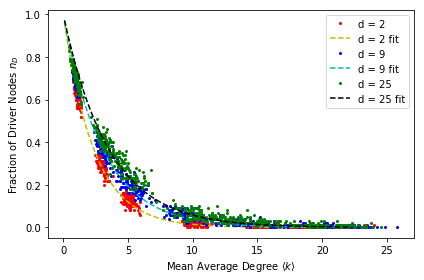

In [3]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt 
import experiment as ex
from network_generation import generation as ng
from scipy import optimize
from scipy.odr import * 

plt.figure()

# FITTING MODEL
def f(B, x):
    return np.exp(B[0]*x)

kappa_range = [1,3,5,10,15,20]
kappa_range_fine = np.arange(.1,22,.01)
n = 100
num_radii = 10
boundary = 's'
d_range = [2,9,25] #[2,3,6,9,15,25,40]

gammas = []
gamma_errs = []

colors = ['ro','yo','bo','co','go','ko']
i=0

handles = []
labels = []
for d in d_range:
    RGG = ex.RGGExperiment(kappa_range, n, d, shortcut_prob=0, boundary=boundary, num_radii=num_radii)

    mean_degree_list, std_degree_list, stddev_degree_list = RGG.find_degree_stats()
    mean_nD_list, std_nD_list, stddev_nD_list = RGG.find_nD_stats()
    
    for ensemble in RGG.ensembles:
        for sample in ensemble.samples:
            data, = plt.plot(sample.mean_degree(),float(sample.find_num_unmatched())/sample.n,colors[i],markersize=2)
    handles.append(data)
    labels.append('d = '+str(d))
            
    x = mean_degree_list
    y = mean_nD_list 
#     plt.errorbar(x, y, fmt='none', yerr=std_nD_list, xerr=std_degree_list)
    # fitting 
    # popt = optimize.curve_fit(lambda t,b:np.exp(b*t), RGG.mean_degree_list, RGG.mean_nD_list)
    wx = [s+1 for s in std_degree_list]
    wy = [s+1 for s in std_nD_list] 
    
    output = odr(f,[-0.5],y,x,wd=wx,we=wy)
    
    i+=1

    fit, = plt.plot(kappa_range_fine,f(output[0],kappa_range_fine),color=colors[i][0],linestyle='--')
    
    gammas.append(output[0][0])
    # 95% confidence is 2*standard error 
    gamma_errs.append(2*(output[1][0]))
    print str(d) +'th dimension done'
    
    i+=1
        
    handles.append(fit)
    labels.append('d = ' + str(d) + ' fit')
    
plt.xlabel('Mean Average Degree $\\langle{k}\\rangle$')
plt.ylabel('Fraction of Driver Nodes $n_D$')
plt.legend(handles,labels)
plt.tight_layout()
plt.savefig('./plots/scatter_k_nD_BC_' + str(boundary) + '_N_' + str(n) + '.eps',dpi=800)

## ER scatter, simulation, cavity, fitting

In [27]:
def find_ER_nD(kappa, plot=False):
        
    # make sure this is a float!
    z0 = float(kappa/2)
    w1irange = np.arange(0,1,.01)
    w1o = lambda x: np.exp(-z0*np.exp(-z0*x))
    w1i = lambda y: -(1/z0)*np.log((1/z0)*np.log(1/y))

    if plot:
        plt.figure()
        plt.plot(w1irange,[w1o(i) for i in w1irange])
        plt.plot(w1irange,w1irange,'k-')
        
        w1o = lambda x: np.exp(-z0*np.exp(-z0*x))
    w1i = lambda y: -(1/z0)*np.log((1/z0)*np.log(1/y))
    
    # BABY NEWTON METHOD 
    xold = 0.5
    yold = 0.5
    check = 100
    while abs(check)>0.001:

        # move up
        ynew = w1o(xold)
        # move right 
        xnew = ynew
        
        if plot: 
            plt.plot((xold,xold),(yold,ynew),'r-')
            plt.plot((xold,xnew),(ynew,ynew),'r-')

        # compute check 
        check = xold - xnew 

        # update for next iteration
        xold = xnew 
        yold = ynew

    w1 = xnew 
    w2 = 1 - np.exp(-z0*w1)
    nD = w1 - w2 + z0*w1*(1-w2)

    return nD

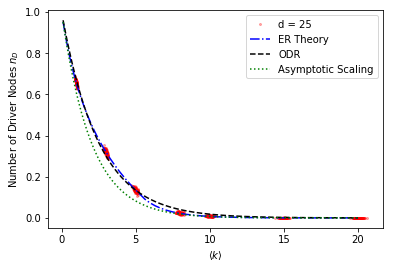

In [37]:
plt.figure(3)

handles = []
labels = []

### DATA ###
kappa_range = [1,3,5,8,10,15,20]
n = 1000

ERE = ex.ERExperiment(kappa_range, n)

mean_degree_list, std_degree_list, stddev_degree_list = ERE.find_degree_stats()
mean_nD_list, std_nD_list, stddev_nD_list = ERE.find_nD_stats()

i=0
for ensemble in ERE.ensembles:
    for sample in ensemble.samples:
        data, = plt.plot(sample.mean_degree(),float(sample.find_num_unmatched())/sample.n,colors[i],markersize=2,alpha=0.3)
handles.append(data)
labels.append('d = '+str(d))

# sim = plt.errorbar(mean_degree_list,mean_nD_list,fmt='ro',markersize=3,ecolor='r',xerr=std_degree_list,yerr=std_nD_list)

kappa_range_fine = np.arange(.1,20,.01)
nD_list = []
for kappa in kappa_range_fine:
    nD_list.append(find_ER_nD(kappa))
theory, = plt.plot(kappa_range_fine,nD_list,'b-.')
handles.append(theory)
labels.append('ER Theory')

#### ODR ####

# first run OLS to get a guess # 
popt = optimize.curve_fit(lambda t,b:np.exp(b*t), mean_degree_list, mean_nD_list)

# MODEL
def f(B, x):
    return np.exp(B[0]*x)

x = mean_degree_list
y = mean_nD_list 
wx = [s+1 for s in std_degree_list]
wy = [s+1 for s in std_nD_list] 

exponential = Model(f)
data = Data(x, y, wd=wx, we=wy)
odr = ODR(data, exponential, beta0=popt[0])
output = odr.run()

fit, = plt.plot(kappa_range_fine,np.exp(output.beta[0]*kappa_range_fine),'k--')
handles.append(fit)
labels.append('ODR')

thermo, = plt.plot(kappa_range_fine,[np.exp(-kappa/2) for kappa in kappa_range_fine],'g:')
handles.append(thermo)
labels.append('Asymptotic Scaling')

plt.xlabel('$\\langle{k}\\rangle$')
plt.ylabel('Number of Driver Nodes $n_D$')
plt.legend(handles,labels)
plt.savefig('./plots/ER_testing.eps')

## make a small graph to show where the driver nodes are 

In [1]:
# PARAMS 
kappa, n, d = 7, 100, 2

RGGs = ng.RGGEnsemble(kappa, n, d, boundary='s', num_radii=1).create_sample()
RGGs.plot_network(unmatched=RGGs.find_unmatched())

NameError: name 'ng' is not defined

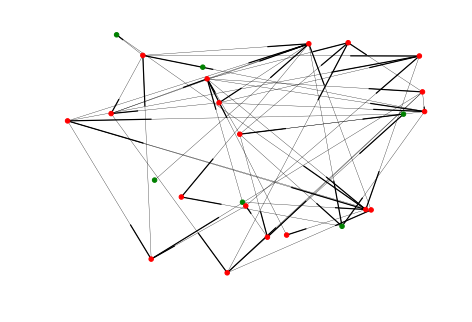

In [15]:
ER = ng.EREnsemble(kappa, n).create_sample()
ER.plot_network(unmatched=ER.find_unmatched())